In [2]:
!pip install numpy
!pip install pandas
!pip install matplotlib

     |████████████████████████████████| 20.3MB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 3.4MB/s eta 0:00:01
     |████████████████████████████████| 512kB 52.5MB/s eta 0:00:01
     |████████████████████████████████| 13.1MB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 92kB 25.3MB/s eta 0:00:01
     |████████████████████████████████| 71kB 20.9MB/s eta 0:00:01


In [3]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import concurrent.futures

In [4]:
from platform import python_version
print(python_version())

3.7.3


In [3]:
class cutter:
    
    def __init__(self, BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data):
        self.BR = BR # cutter back rake angle
        self.Vc = Vc # cutter velocity
        self.DOC_data = cutter_DOC_data_list # list of cutter depth of cut (data)
        self.IFA_data = cutter_IFA_data_list # list of cutter IFA values (data)
        self.VN = Vc / 2.1 # normalized cutter velocity
        self.UCS = UCS # rock unconfined compressive strength
        self.UCSN = UCS / 5000 # normalized rock unconfined compressive strength
        self.Dc = Dc # cutter diameter
        self.Rc = Dc/2 # cutter radius
        self.Aw = Aw # wearflat area sq-inch
        self.Fn_data = cutter_Fn_data # cutter normal force. for blunt cutter case.
        self.Fd_data = cutter_Fd_data # cutter drag force. for blunt cutter case.
        
    def Model_IFA(self, DOC,w):
        ''' A model for IFA calculation. it takes DOC,
        normalized cutter velocity, normalized rock 
        UCS and cutter back rake and returns the IFA.'''
        DOCn = DOC / self.Dc # normalize DOC 
        C1 = w[0] + (w[1])/((self.VN)**w[2] + w[3])
        C2 = w[4] + (w[5])/((self.VN)**w[6]+ w[7])
        C_P = w[8]
        C3 = w[9] + w[10]/((self.UCSN**w[11])+w[12])
        return (C1+C2/((DOCn**C_P)+C3))-self.BR
    
    def Find_L(self):
        '''A function that search for L on cutter face.
        Applicable to blunt cutter.'''
        diff = 10
        L = 0
        while diff > 0.0001:
            L += 0.00001
            A_segment_esti = ((self.Rc)**2*math.acos((self.Rc-L)/self.Rc)\
                       -(self.Rc-L)*((self.Dc*L-(L)**2)**0.5))
            diff = abs(self.Aw_on_cutter_face-A_segment_esti)
        return L
    
    def Calculate_fitness(self, w):
        
        if self.Aw == 0:
            
            self.IFA_using_Model = [self.Model_IFA(DOC,w) for DOC in self.DOC_data]
            self.ABS_Error = sum([abs((i-j)/i) for i,j in zip(self.IFA_data,self.IFA_using_Model)])/len(self.DOC_data)
            
        else:
                        
            self.Fn_Fd_list = [i / j for i, j in zip(self.Fn_data, self.Fd_data)] # cutter normal to drag force ratio
            self.IFA_list_DD_Model = [((math.atan(Fn_Fd)*180)/math.pi-self.BR) for Fn_Fd in self.Fn_Fd_list] # calculated IFA list
            self.IFA_list_with_Model = [self.Model_IFA(DOC,w) for DOC in self.DOC_data]
            self.Aw_on_cutter_face = self.Aw*math.cos(math.radians((90-self.BR)))
            self.L_list = [(DOC/math.cos(math.radians(self.BR))) for DOC in self.DOC_data] # DOC projected length on cutter face
            self.L_worn = self.Find_L() # single value
            self.Total_L = [(self.L_worn + L) for L in self.L_list] # total L, summation 
            self.A_total_segment = [((self.Rc)**2*math.acos((self.Rc-L)/self.Rc)-(self.Rc-L)*((self.Dc*L-(L)**2)**0.5)) for L in self.Total_L]
            self.A_real_contact_list = [(a-self.Aw_on_cutter_face) for a in self.A_total_segment]
            #============================================================================================
            self.A_F_list_without_IFA = [(A_contact*math.cos(math.radians(self.BR))) for A_contact in self.A_real_contact_list] 
            self.F_d_without_IFA = [A_F * self.UCS for A_F in self.A_F_list_without_IFA]
            self.A_F_list_with_IFA = [(A_contact*math.cos(math.radians(IFA+self.BR))) for IFA, A_contact in zip(self.IFA_list_with_Model, self.A_real_contact_list)] 
            self.F_d_with_IFA = [A_F * self.UCS for A_F in self.A_F_list_with_IFA]
            self.A_B_list_without_IFA = [(A_contact*math.sin(math.radians(self.BR))) for A_contact in self.A_real_contact_list] 
            self.F_n_without_IFA = [A_B * self.UCS for A_B in self.A_B_list_without_IFA]
            self.A_B_list_with_IFA = [(A_contact*math.sin(math.radians(IFA+self.BR))) for IFA, A_contact in zip(self.IFA_list_with_Model, self.A_real_contact_list)] 
            self.F_n_with_IFA = [A_B * self.UCS for A_B in self.A_B_list_with_IFA]
            #============================================================================================
            miu = 0.6 # internal friction coefficient for SWG
            self.F_n_with_IFA_miu = [Fn + self.Aw*self.UCS for Fn in self.F_n_with_IFA]
            self.F_d_with_IFA_miu = [Fd+(self.Aw*self.UCS*miu) for Fd in self.F_d_with_IFA]
            #============================================================================================
            self.ABS_Error_Fn = sum([abs((i-j)/j) for i,j in zip(self.F_n_with_IFA_miu, self.Fn_data)])/len(self.DOC_data)
            self.ABS_Error_Fd = sum([abs((i-j)/j) for i,j in zip(self.F_d_with_IFA_miu, self.Fd_data)])/len(self.DOC_data)
            self.ABS_Error = self.ABS_Error_Fn + self.ABS_Error_Fd
        return (self.ABS_Error)   

### Data for Case1: UCS = 3000 psi, Vc = 2.1 in/sec, BR = 20, Dc = 0.5"

In [4]:
case1_DOC_data = [0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055\
                ,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12]
case1_IFA_data = [10,10,10,10,10,10,10,10,10,10,10,10,10,\
                         10,10,10,10,10,10,10,10,10,10,10,10]
case1_Fn_data = 0
case1_Fd_data = 0

#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case1 = cutter(20, 2.1, 3000, 0.5, 0, case1_DOC_data, case1_IFA_data, case1_Fn_data, case1_Fd_data)
#print('Case1 details',case1.__dict__)

### Data for Case2: UCS = 7100 psi, Vc = 2.1 in/sec, BR = 20, Dc = 0.5"

In [5]:
case2_DOC_data = [0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055\
                ,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12]
case2_IFA_data = [20,20,20,20,20,20,20,20,20,20,20,20,20,20,\
                         20,20,20,20,20,20,20,20,20,20,20]
case2_Fn_data = 0
case2_Fd_data = 0

#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case2 = cutter(20, 2.1, 7100, 0.5, 0, case2_DOC_data, case2_IFA_data, case2_Fn_data, case2_Fd_data)
#print('Case2 details',case2.__dict__)

### Data for Case3: UCS = 21500 psi, Vc = 2.1 in/sec, BR = 20, Dc = 0.5"

In [6]:
case3_DOC_data = [0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055\
                ,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12]
case3_IFA_data = [62.49,44.78,38.80,35.67,33.61,32.09,30.90,29.93,29.12,28.42,27.80,\
                         27.26,26.77,26.33,25.93,25.57,25.23,24.91,24.62,24.34,24.09,23.85,\
                         23.62,23.40,23.20]
case3_Fn_data = 0
case3_Fd_data = 0

#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case3 = cutter(20, 2.1, 21500, 0.5, 0, case3_DOC_data, case3_IFA_data, case3_Fn_data, case3_Fd_data)
#print('Case3 details',case3.__dict__)

### Data for Case4: UCS = 19400 psi, Vc = 177 in/sec, BR = 5, Dc = 0.5"

In [7]:
case4_DOC_data = [0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055\
                ,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12]
case4_IFA_data = [107.23,89.83,83.24,79.61,77.13,75.26,73.76,72.52,71.47,70.55,\
                         69.73,69.01,68.35,67.75,67.20,66.69,66.22,65.78,65.37,\
                         64.98,64.61,64.27,63.94,63.63,63.33]
case4_Fn_data = 0
case4_Fd_data = 0

#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case4 = cutter(20, 177, 19400, 0.5, 0, case4_DOC_data, case4_IFA_data, case4_Fn_data, case4_Fd_data)
#print('Case4 details',case4.__dict__)

### Data for Case5: UCS = 19400 psi, Vc = 177 in/sec, BR = 10, Dc = 0.5"

In [8]:
case5_DOC_data = [0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055\
                ,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12]
case5_IFA_data = [91.54,79.45,74.75,72.13,70.33,68.96,67.86,66.95,\
                         66.16,65.48,64.88,64.34,63.84,63.40,62.98,62.60,\
                         62.25,61.92,61.61,61.31,61.04,60.78,60.53,60.29,60.07]
case5_Fn_data = 0
case5_Fd_data = 0

#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case5 = cutter(10, 177, 19400, 0.5, 0, case5_DOC_data, case5_IFA_data, case5_Fn_data, case5_Fd_data)
#print('Case5 details',case5.__dict__)

### Data for Case6: UCS = 19400 psi, Vc = 177 in/sec, BR = 15, Dc = 0.5"

In [9]:
case6_DOC_data = [0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055\
                ,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12]
case6_IFA_data = [91.14,77.21,71.89,68.95,66.94,65.42,64.20,63.19,\
                         62.33,61.58,60.91,60.32,59.78,59.29,58.84,58.42,\
                         58.03,57.67,57.33,57.01,56.71,56.43,56.16,55.90,55.66]
case6_Fn_data = 0
case6_Fd_data = 0

#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case6 = cutter(15, 177, 19400, 0.5, 0, case6_DOC_data, case6_IFA_data, case6_Fn_data, case6_Fd_data)
#print('Case6 details',case6.__dict__)

### Data for Case7: UCS = 19400 psi, Vc = 177 in/sec, BR = 20, Dc = 0.5"

In [10]:
case7_DOC_data = [0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055\
                ,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12]
case7_IFA_data = [82.65,70.59,65.96,63.39,61.63,60.29,59.22,58.34,\
                         57.58,56.92,56.33,55.81,55.34,54.90,54.51,54.14,\
                         53.80,53.48,53.18,52.90,52.63,52.38,52.14,51.92,51.70]
case7_Fn_data = 0
case7_Fd_data = 0

#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case7 = cutter(20, 177, 19400, 0.5, 0, case7_DOC_data, case7_IFA_data, case7_Fn_data, case7_Fd_data)
#print('Case7 details',case7.__dict__)

### Data for Case8: UCS = 19400 psi, Vc = 177 in/sec, BR = 25, Dc = 0.5"

In [11]:
case8_DOC_data = [0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055\
                ,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12]
case8_IFA_data = [99.48,77.14,69.14,64.85,61.97,59.82,58.12,56.72,\
                         55.54,54.51,53.61,52.81,52.09,51.44,50.84,50.29,\
                         49.78,49.30,48.86,48.44,48.05,47.68,47.33,47.00,46.69]
case8_Fn_data = 0
case8_Fd_data = 0

#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case8 = cutter(25, 177, 19400, 0.5, 0, case8_DOC_data, case8_IFA_data, case8_Fn_data, case8_Fd_data)
#print('Case8 details',case8.__dict__)

### Data for Case9: UCS = 19400 psi, Vc = 177 in/sec, BR = 30, Dc = 0.5"

In [12]:
case9_DOC_data = [0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055\
                ,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12]
case9_IFA_data = [76.83,62.32,56.95,54.03,52.04,50.56,49.37,48.39,\
                         47.56,46.84,46.20,45.63,45.12,44.65,44.22,43.83,\
                         43.46,43.12,42.80,42.50,42.22,41.95,41.70,41.46,41.23]
case9_Fn_data = 0
case9_Fd_data = 0

#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case9 = cutter(30, 177, 19400, 0.5, 0, case9_DOC_data, case9_IFA_data, case9_Fn_data, case9_Fd_data)
#print('Case9 details',case9.__dict__)

### Data for Case10: UCS = 21500 psi, Vc = 2.1 in/sec, BR = 20 , Dc = 0.75", Aw = 0.02 sq-inch

In [13]:
case10_DOC_data = [0.023,0.023,0.023,0.023,0.024,0.024,0.024,0.024,0.039,0.04,\
                0.04,0.04,0.041,0.041,0.041,0.042,0.042,0.042,0.042,0.042,\
                0.042,0.042,0.079,0.079,0.079,0.079,0.08]
case10_IFA_data = 0
case10_Fn_data = [545,568,599,590,610,617,640,619,657,689,699,756,669,676,698,\
               770,770,739,763,741,774,760,855,865,926,918,875]
case10_Fd_data = [360,387,392,396,401,412,418,416,461,475,476,517,466,473,481,\
               511,540,518,526,504,522,519,694,694,722,750,710]

#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case10 = cutter(20, 2.1, 21500, 0.75, 0.02, case10_DOC_data, case10_IFA_data, case10_Fn_data, case10_Fd_data)
#print('Case10 details',case10.__dict__)

In [14]:
class Full_bit:
    
    def __init__(self, name, ROP_constant, Data_WOB, Data_RPM, Data_ROP, Db, UCS, CP, NOC, BR, Dc, NOB):
        
        self.name = name
        self.ROPcons = ROP_constant
        self.Data_WOB = Data_WOB
        self.Data_RPM = Data_RPM
        self.Data_ROP = Data_ROP
        self.Data_WOB.sort()
        self.Data_ROP.sort()
        self.Db = Db
        self.UCS = UCS
        self.NOC = NOC
        self.BR = BR
        self.Dc = Dc
        self.NOB = NOB
        self.CP = CP
        
        
        # adjust the UCS for CP using data from 
        # Winters, W. J., T. M. Warren, and E. C. Onyia. 
        #"Roller bit model with rock ductility and cone offset." 
        #In SPE Annual Technical Conference and Exhibition. 
        #Society of Petroleum Engineers, 1987.
        
        if self.UCS == 10900: #carthage lime
            # incldue the effect of CP
            self.UCS = -0.0002*self.CP**2 + 3.6048*self.CP + 10000
            
        elif self.UCS == 7100: #BSS lime
            # incldue the effect of CP
            self.UCS = -0.00028*self.CP**2 + 10.4*self.CP + 7400
            
        elif self.UCS == 21500: #SWG
            # incldue the effect of CP
            self.UCS = self.UCS
        else: #Catoosa Shale lime
            # incldue the effect of CP
            self.UCS = -0.0002*self.CP**2 + 2.95*self.CP + 5100
        
        
        
        self.Ac = math.pi*self.Dc**2 / 4 # cutter face area sq-inch
        self.AB_max = self.Ac*math.sin(math.radians(self.BR))
        self.Re = self.Db/(2*(2**0.5)) # calculate the equivalent radius
        #self.Number_of_DataPoints = len(self.Data_WOB_cont) # continuous
        self.Number_of_DataPoints = len(self.Data_WOB) # non.continuous
        #self.WOC = [self.Data_WOB_cont[i]/self.NOC for i in range(0,self.Number_of_DataPoints)] # calculate the weight on cutter - continuous
        self.WOC = [self.Data_WOB[i]/self.NOC for i in range(0,self.Number_of_DataPoints)] # calculate the weight on cutter - non.continuous
        self.A_bit = (math.pi*(self.Db**2))/4 # bit area
        self.AB = [WOC/self.UCS for WOC in self.WOC ] # calculate the cutter beanth area
        self.AB = [self.AB_max if x > self.AB_max else x for x in self.AB] # filter those values that are greater than availabe cutter beanth area
        self.UCSN = self.UCS/5000 # calculate the normalized UCS
        self.V_Cutter_Equivalent = [2*math.pi*self.Re*RPM/60 for RPM in self.Data_RPM] # calculate equivalent velocity
        self.VN = [V_Cutter_Equivalent/2.1 for V_Cutter_Equivalent in self.V_Cutter_Equivalent] # normalize the equivalent velocity
        
        
    def A_Front(self, AB, IFA):
        '''A function that takes the cutter beneath area,
        back rake and IFA and returns the cutter front area.'''
        return AB/math.tan(math.radians(self.BR+IFA))

    def ROP_model(self, AF, RPM):
        '''A ROP model (function). A function that takes number of cutters (NOC),
        bit equivalent radius (Re), cutter front area (AF), cutter back rake (BR),
        interfacial friction angle (IFA), revolutions per minute (RPM), and bit area (A_bit).'''
        return ((2*self.NOC*math.pi*self.Re*AF*RPM)/(self.A_bit))*5
        
        
    def Model_IFA(self, DOC, VN, w):
        #A model for IFA calculation. it takes DOC,
        #normalized cutter velocity, normalized rock 
        #UCS and cutter back rake and returns the IFA.

        DOCn = DOC / self.Dc # normalize DOC
        a = w[0] + (w[1])/((VN)**w[2] + w[3])
        b = w[4] + (w[5])/((VN)**w[6]+ w[7])
        c = w[8]
        d = w[9] + w[10]/((self.UCSN**w[11]) + w[12])
        
        return (a+b/((DOCn**c)+d))-self.BR
    
    
    
    def Find_IFA(self, AB, maxvalue, RPM, VN, w):
        #A function that finds the best IFA value that satisfy 
        #both the ROP DOC and developed Model-IFA
        diff1 = 1000000000000000 # initite it with a big value
        IFA_search = 0

        while diff1 > 0.0001 and IFA_search < maxvalue:

            IFA_search = IFA_search + 0.1
            AF = self.A_Front(AB,IFA_search) #calculate the cutter front area
            ROP = self.ROP_model(AF, RPM) # calculate the ROP
            DOC = ROP/(RPM*5) # calculate the depth of cut
            IFA = self.Model_IFA(DOC, VN, w)
            diff2 = abs(IFA_search - IFA)
            
            if diff2 < diff1:
                diff1 = diff2
                self.Best_IFA = IFA_search
                
            '''IFA_search = list(range(0,((90-self.BR)*10),1))
            IFA_search = [i/10 for i in IFA_search]
            AF = [self.A_Front(AB,IFA_search) for IFA_search in IFA_search]
            ROP = [self.ROP_model(AF) for AF in AF]
            DOC = [ROP/(self.RPM*5) for ROP in ROP] # calculate the depth of cut
            IFA = [self.Model_IFA(DOC) for DOC in DOC]
            diff2 = [abs(IFA_search - IFA) for IFA in IFA]
            Dic = {'IFA_search':IFA_search, 'AF':AF, 'ROP':ROP, 'DOC':DOC, 'IFA':IFA, 'diff2':diff2}
            diff1 = min(Dic['diff2'])
            self.Best_IFA = min(Dic['diff2'])'''
            

        return self.Best_IFA, diff1
    
    
    
    def Calculate_ROP(self, AB, maxvalue, RPM, VN, w):
        ''' A function that takes the cutter beneath
        area and returns the ROP estimated'''
        IFA, diff = self.Find_IFA(AB, maxvalue, RPM, VN, w)
        AF = self.A_Front(AB,IFA)
        Estimated_ROP = self.ROPcons * self.ROP_model(AF, RPM)
        return Estimated_ROP, IFA, diff
    
    def Calculate_fitness(self, w):
        
        #===========================================================================================================
        #ROP calculation
        self.ROP_Model_esti_list = []
        self.IFAlist = []
        self.difflist = []
        self.maxvalue = 90 - self.BR
    
        for i in range(0,self.Number_of_DataPoints):
            self.ROP_Model_esti, IFA, diff = self.Calculate_ROP(self.AB[i], self.maxvalue, self.Data_RPM[i], self.VN[i], w)
            self.ROP_Model_esti_list.append(self.ROP_Model_esti)
            self.difflist.append(diff)
            self.maxvalue = IFA # make sure descending trend for IFA vs DOC
            self.IFAlist.append(IFA)
        #===========================================================================================================    
        self.error_ROP_list = [abs((ROP_Model - Data_ROP)/Data_ROP) for ROP_Model, Data_ROP in zip(self.ROP_Model_esti_list,self.Data_ROP)]
        self.error_ROP = sum(self.error_ROP_list)/len(self.Data_WOB)
        return self.error_ROP
        
        
        


### Carthage Lime - 8.5" PDC bit

In [15]:
ROP_constant = 0.55

In [16]:
#Data for Carthage lime
Data_WOB = [2744.23,2721.55,5356.93,6608.84,2585.48,2608.16,5270.74,6518.12,8545.68,8532.07] # insert the WOB data into the list
Data_ROP = [9.77,9.57,27.38,34.53,7.74,8.09,22.18,29.77,42.48,42.95] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[120]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'                                                                                                  #'name, ROP_constant, Data_WOB, Data_RPM, Data_ROP, Db,   UCS,   CP, NOC, BR, Dc, NOB'
case3_FullBit = Full_bit('5600m to 5609m-Carthage lime, LPM~1700, CP~1400 psi,\n PV = 8, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 1400, 49, 20, 0.5, 7)


#Data for Carthage lime
Data_WOB = [408.23,1251.91,2540.12,4209.34,6227.82,8314.35] # insert the WOB data into the list
Data_ROP = [0.68,3.85,13.31,24.45,43.60,59.02] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[170]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case4_FullBit = Full_bit('5610m to 5615m-Carthage lime, LPM~1700, CP~920 psi,\n PV = 12, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 920, 49, 20, 0.5, 7)


#Data for Carthage lime
Data_WOB = [408.23,1265.52,2562.80,4286.45,6368.44,8454.96] # insert the WOB data into the list
Data_ROP = [0.55,3.19,9.10,17.61,31.26,55.18] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[120]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case5_FullBit = Full_bit('5616m to 5621m-Carthage lime, LPM~1700, CP~807 psi,\n PV = 13, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 807, 49, 20, 0.5, 7)


#Data for Carthage lime
Data_WOB = [340.19,1202.02,2444.86,3996.15,6114.42] # insert the WOB data into the list
Data_ROP = [0.59,4.80,16.11,39.19,53.10] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[120]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case6_FullBit = Full_bit('5626m to 5630m-Carthage lime, LPM~1700, CP~1125 psi,\n PV = 15, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 1125, 49, 20, 0.5, 7)


#Data for Carthage lime
Data_WOB = [294.84,317.51,1460.57,2721.55,4036.97,5352.39] # insert the WOB data into the list
Data_ROP = [4.3617,5.1603,17.5656,22.7320,22.9758,28.0325] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[120]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case7_FullBit = Full_bit('5631m to 5636m-Carthage lime, LPM~1700, CP~1444 psi,\n PV = 8, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 1444, 49, 20, 0.5, 7)


#Data for Carthage lime
Data_WOB = [90.72,272.16,1383.46,2508.37,3887.29,5493.00,6758.53] # insert the WOB data into the list
Data_ROP = [16.07,2.01,18.50,29.78,30.66,38.18,46.60] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[120]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case8_FullBit = Full_bit('5637m to 5643m-Carthage lime, LPM~1700, CP~1560 psi,\n PV = 5, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 1560, 49, 20, 0.5, 7)


#Data for Carthage lime
Data_WOB = [362.87,1179.34,2490.22,4154.91,5325.17,5325.17] # insert the WOB data into the list
Data_ROP = [2.75,9.38,14.40,28.33,44.67,45.33] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[155]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case9_FullBit = Full_bit('5644m to 5649m-Carthage lime, LPM~1700, CP~800 psi,\n PV = 13, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 800, 49, 20, 0.5, 7)


#Data for Carthage lime
Data_WOB = [2585.48,2608.16,5270.74,6518.12,8545.68,8532.07] # insert the WOB data into the list
Data_ROP = [7.74,8.09,22.18,29.77,42.48,42.95] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[120]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case21_FullBit = Full_bit('Carthage lime, PV = 12, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 1200, 49, 13, 0.5, 7)


#Data for Carthage lime
Data_WOB = [408.23,1251.91,2540.12,4209.34,6227.82,8314.35] # insert the WOB data into the list
Data_ROP = [0.68,3.85,13.31,24.45,43.60,59.02] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[175]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case22_FullBit = Full_bit('Carthage lime, PV = 12, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 1200, 49, 13, 0.5, 7)


#Data for Carthage lime
Data_WOB = [408.23,1265.52,2562.80,4286.45,6368.44,8454.96] # insert the WOB data into the list
Data_ROP = [0.55,3.19,9.10,17.61,31.26,55.18] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[120]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case23_FullBit = Full_bit('Carthage lime, PV = 12, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 1200, 49, 13, 0.5, 7)


#Data for Carthage lime
Data_WOB = [340.19,1202.02,2444.86,3996.15,6114.42] # insert the WOB data into the list
Data_ROP = [0.59,4.80,16.11,39.19,53.10] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[120]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case24_FullBit = Full_bit('Carthage lime, PV = 12, UCS = 10900 psi',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 8.5, 10900, 362, 49, 13, 0.5, 7)



# Reedhycalog data

In [17]:
#Data for SWG
Data_WOB = [2200, 2800, 3200, 3550, 4000, 4500, 4900] # insert the WOB data into the list
Data_ROP = [2, 5, 10, 16.5, 26.5, 34.5, 41] # insert the ROP data into the list
Data_RPM = len(Data_WOB)*[80]
#'(name, ROP_constant, Data_WOB_cont, Data_WOB, Data_ROP, Db, RPM, UCS, CP, NOC, BR, Dc, NOB)'
case25_FullBit = Full_bit('Reedhycalog, 80 RPM, SWG',ROP_constant, Data_WOB, Data_RPM, Data_ROP, 3.75, 21500, 0, 12, 20, 0.5, 7)

# DEA

In [18]:
def de(fobj, bounds, mut=0.8, crossp=0.7, popsize=100, its=10):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        #print("Iteration number= %s" % (i))
        #print("Best Fitness= %s" % (fitness[best_idx]))
        #print("Best values= %s" % (best))
        yield best, fitness[best_idx]

In [19]:
#Define objective function-min sq
def ERROR(w):
    #============================
    w = w.tolist()
    #=====================================
    ERROR_value1 =\
    case3_FullBit.Calculate_fitness(w)+\
    case4_FullBit.Calculate_fitness(w)+\
    case5_FullBit.Calculate_fitness(w)+\
    case6_FullBit.Calculate_fitness(w)+\
    case7_FullBit.Calculate_fitness(w)+\
    case8_FullBit.Calculate_fitness(w)+\
    case9_FullBit.Calculate_fitness(w)+\
    case21_FullBit.Calculate_fitness(w)+\
    case22_FullBit.Calculate_fitness(w)+\
    case23_FullBit.Calculate_fitness(w)+\
    case24_FullBit.Calculate_fitness(w)+\
    case25_FullBit.Calculate_fitness(w)
    #=====================================
    
    ERROR_value2 =\
    case1.Calculate_fitness(w)+\
    case2.Calculate_fitness(w)+\
    case3.Calculate_fitness(w)+\
    case4.Calculate_fitness(w)+\
    case5.Calculate_fitness(w)+\
    case6.Calculate_fitness(w)+\
    case7.Calculate_fitness(w)+\
    case8.Calculate_fitness(w)+\
    case9.Calculate_fitness(w)+\
    case10.Calculate_fitness(w)
    
    #=====================================
    ERROR_value1 = ERROR_value1 / 12
    #=====================================   
    #ERROR_value1 = case25_FullBit.Calculate_fitness(w)
    a = case2.Calculate_fitness(w)+case3.Calculate_fitness(w)+\
    case10.Calculate_fitness(w)
    a = a / 3
    b = case4.Calculate_fitness(w)+case5.Calculate_fitness(w)+\
    case6.Calculate_fitness(w)+case7.Calculate_fitness(w)+\
    case8.Calculate_fitness(w)+case9.Calculate_fitness(w)
    b = b / 6
    c = (a + b) / 2
    ERROR_value2 = c
    #============================
    ERROR_value = (ERROR_value1 + ERROR_value2) / 2
    #============================
    return (ERROR_value)

# Parallel computing

In [20]:
'''#Define objective function-min sq
def ERROR(w):

    #============================
    w = w.tolist()
    #============================
    with concurrent.futures.ProcessPoolExecutor() as executor:
        
        f1 = executor.submit(case1_FullBit.Calculate_fitness, w)
        f2 = executor.submit(case2_FullBit.Calculate_fitness, w)
        f3 = executor.submit(case3_FullBit.Calculate_fitness, w)
        f4 = executor.submit(case4_FullBit.Calculate_fitness, w)
        f5 = executor.submit(case5_FullBit.Calculate_fitness, w)
        f6 = executor.submit(case6_FullBit.Calculate_fitness, w)
        
        f7 = executor.submit(case1.Calculate_fitness, w)
        f8 = executor.submit(case2.Calculate_fitness, w)
        f9 = executor.submit(case3.Calculate_fitness, w)
        f10 = executor.submit(case4.Calculate_fitness, w)
        f11 = executor.submit(case5.Calculate_fitness, w)
        f12 = executor.submit(case6.Calculate_fitness, w)
        f13 = executor.submit(case7.Calculate_fitness, w)
        f14 = executor.submit(case8.Calculate_fitness, w)
        f15 = executor.submit(case9.Calculate_fitness, w)
        f16 = executor.submit(case10.Calculate_fitness, w)


    ERROR_value1 =\
    f1.result()+\
    f2.result()+\
    f3.result()+\
    f4.result()+\
    f5.result()+\
    f6.result()

    #============================
    ERROR_value2 =\
    f7.result()+\
    f8.result()+\
    f9.result()+\
    f10.result()+\
    f11.result()+\
    f12.result()+\
    f13.result()+\
    f14.result()+\
    f15.result()+\
    f16.result()

    #============================
    ERROR_value = (ERROR_value1/6 + ERROR_value2/10)/2
    #============================
    #print(ERROR_value1/ERROR_value2)
    #print(ERROR_value2)

    return (ERROR_value)'''

'#Define objective function-min sq\ndef ERROR(w):\n\n    #============================\n    w = w.tolist()\n    #============================\n    with concurrent.futures.ProcessPoolExecutor() as executor:\n        \n        f1 = executor.submit(case1_FullBit.Calculate_fitness, w)\n        f2 = executor.submit(case2_FullBit.Calculate_fitness, w)\n        f3 = executor.submit(case3_FullBit.Calculate_fitness, w)\n        f4 = executor.submit(case4_FullBit.Calculate_fitness, w)\n        f5 = executor.submit(case5_FullBit.Calculate_fitness, w)\n        f6 = executor.submit(case6_FullBit.Calculate_fitness, w)\n        \n        f7 = executor.submit(case1.Calculate_fitness, w)\n        f8 = executor.submit(case2.Calculate_fitness, w)\n        f9 = executor.submit(case3.Calculate_fitness, w)\n        f10 = executor.submit(case4.Calculate_fitness, w)\n        f11 = executor.submit(case5.Calculate_fitness, w)\n        f12 = executor.submit(case6.Calculate_fitness, w)\n        f13 = executor.sub

In [21]:
start_time = time.time()
#Apply the DE algorithm to the function + boundries and number of iterations
result = list(de(ERROR, [(0, 100),(-200, 0),(0, 2.5),(0, 100),\
                         (0, 100),(-200, 0),(0, 2.5),(0, 100),\
                         (0, 2),\
                         (0, 100),(0, 200),(0, 2.5),(0, 100)], mut=0.7, crossp=0.8, popsize=25, its=1000))
df = pd.DataFrame(result)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3127.0442445278168 seconds ---


In [22]:
print(df.tail(1))

                                                     0         1
999  [19.184400489874037, -127.07982888440776, 0.65...  0.202387


In [23]:
df['w1'], df['w2'],df['w3'], df['w4'], df['w5'],\
df['w6'], df['w7'],df['w8'], df['w9'], df['w10'],\
df['w11'], df['w12'], df['w13']= zip(*df[0])
cols = [0]
df.drop(df.columns[cols],axis=1,inplace=True)
df.columns.values[0] = "Fitness"
best_coff = list(zip(df.iloc[len(df)-1,1:]))
print(best_coff)

[(19.184400489874037,), (-127.07982888440776,), (0.6533611703184311,), (2.685118495557242,), (81.35607013492762,), (-26.052924644320996,), (1.6623591061860816,), (53.15291030463235,), (0.3362859442160266,), (0.010774893849365282,), (102.28585793964906,), (2.4844933007511614,), (97.0366648666049,)]


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


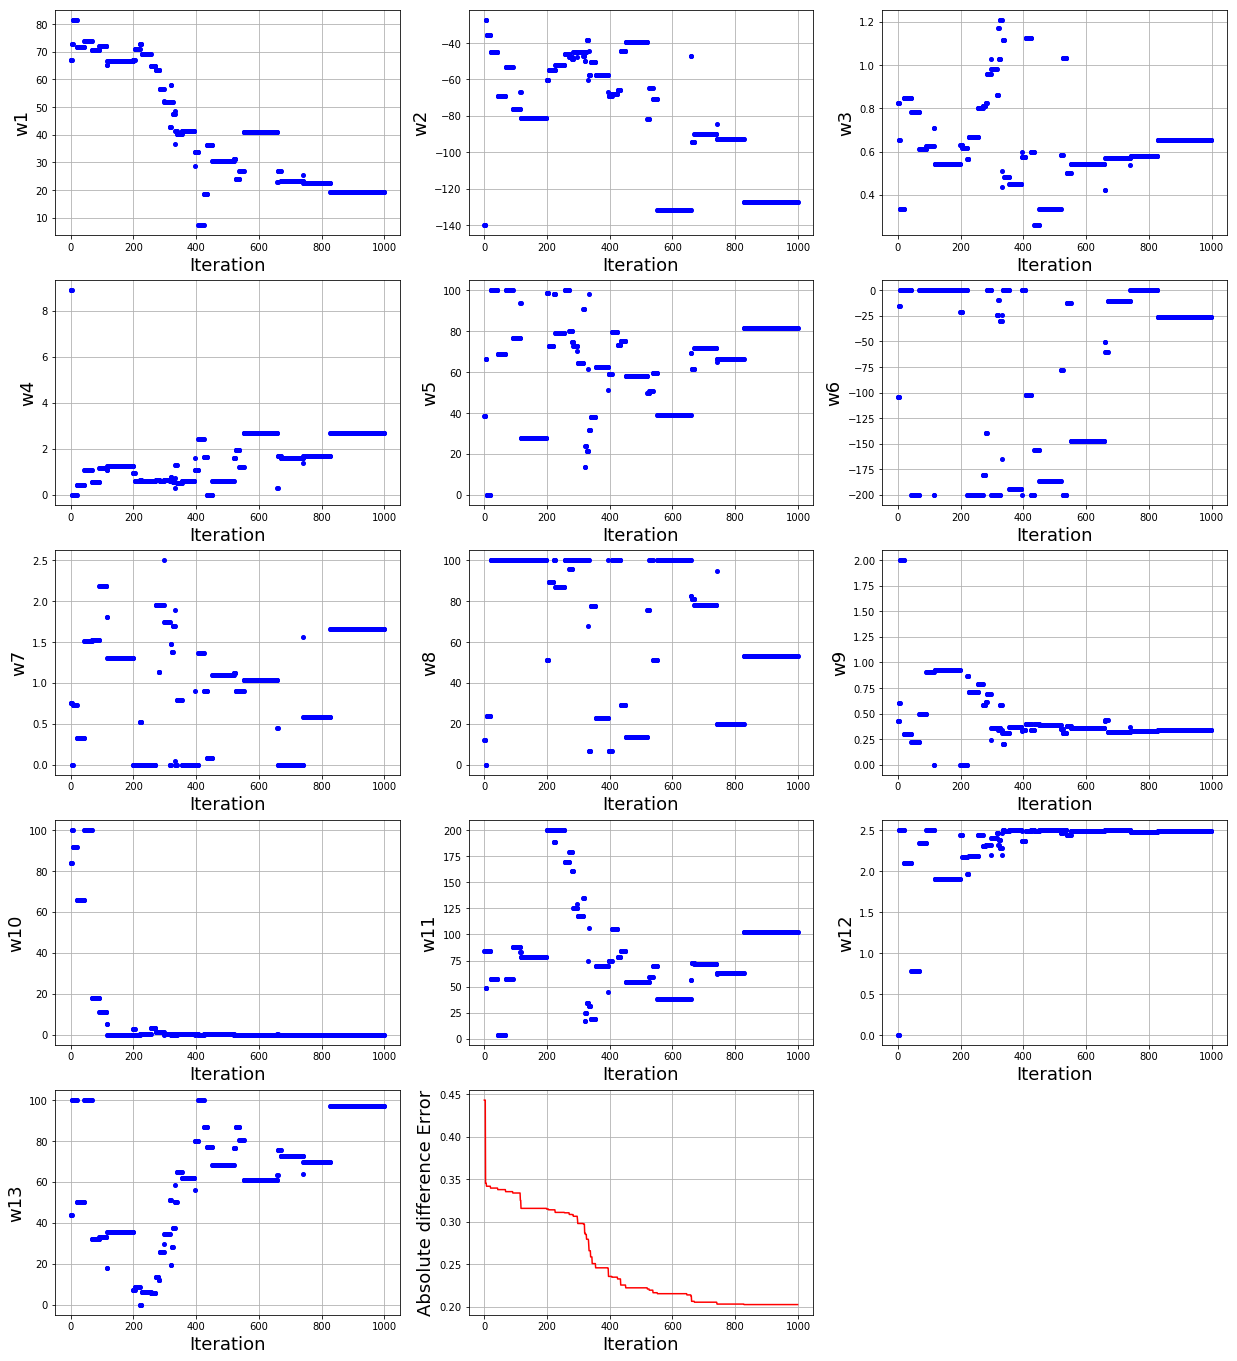

In [24]:
data_ncol=len(df.columns)
#Plot fitness versus iteration
fig = plt.figure(figsize=(21,24))
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

for i in range(1,(data_ncol+1)):
    if i<data_ncol:

        plt.subplot(5, 3, i)
        plt.plot(df['w{}'.format(i)],'bo', markersize=4)
        plt.xlabel('Iteration', fontsize=18)
        plt.ylabel('w{}'.format(i), fontsize=18)
        plt.grid(True)
    else:       

        plt.subplot(5, 3, data_ncol)
        plt.plot(df['Fitness'],'red', markersize=4)
        plt.xlabel('Iteration', fontsize=18)
        plt.ylabel('Absolute difference Error', fontsize=18)
        plt.grid(True)
plt.show()